## Example 2: Fundamental Dipole and Saturation Scale

In this example, we calculate the scattering matrix in both real and momentum space, and extract the saturation momentum scale, $g^2 \mu/Q_s$ from the former.

### References

[1] Dumitru, A., & Skokov, V. (2015). Anisotropy of the semiclassical gluon field of a large nucleus at high energy. Physical Review D, 91(7), 074006. https://doi.org/10.1103/PhysRevD.91.074006 (https://arxiv.org/pdf/1411.6630.pdf)

In [1]:
# If you haven't formally installed the toolbox, you will need
# this line to get proper access to the functions
import sys
sys.path.append('../')

# Import our functions
import cgc

# To make the evaluation responsive and more user friendly
# Can be installed with: pip install progressbar2
import progressbar

# Import numpy and matplotlib for plotting/other utility
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.interpolate import splrep, sproot

# Make our plots nice and large
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 12

In [2]:
M = 4 # Number of configurations  
N = 512  # Lattice size
delta = .05
L = N*delta # S_\perp = L^2 is the area of the target
mu = 1 # defines the units in the calculation

# Collecting and storing configurations of the fundamental Wilson line in real space
V_list = np.zeros([M, N, N, 3, 3], dtype=np.complex128) # The wilson line is a 3x3 matrix at each lattice point

# This step may take a while, so we'll use a progress bar to see how far along we are
# We'll use this several times later on as well
progressBar = progressbar.ProgressBar(max_value=M)

# Generate M targets and calculate their Wilson lines
for i in range(M):
    progressBar.update(i)
    nucleus = cgc.Nucleus(3, N, delta, mu, M=0.1, Ny=100)
    V_list[i] = nucleus.wilsonLine()
progressBar.update(M)

100% (4 of 4) |##########################| Elapsed Time: 0:09:48 ETA:  00:00:00

$$S(\vec k )_{ij} = \frac{\Delta^2}{3 M N^2} \sum_{m}^{M} tr\left( V^{m}_{ij} (V^{m}_{ij})^\dagger \right)$$

In [13]:
# Evaluating the S matrix in momentum and configuration spaces  

S = np.zeros([N, N], dtype=np.complex128)
S_fft = np.zeros([N, N], dtype=np.complex128)

V_fft = fft2(V_list, axes=(1,2),
             workers=-1, # For parallelization
            ) 

for i in range(N):
    for j in range(N):
        S_fft[i,j] += np.sum([np.trace(V_fft[m,i,j] @ np.conjugate(np.transpose(V_fft[m,i,j]))) for m in range(M)])

# Forward norm means no extra factors on the ifft (since we put them in explicitly)
S = ifft2(S_fft, norm='forward') / (3 * M * N**4)
S_fft *= delta**2 / (3 * M * N**2)

We can use the relation

$$ \langle S \rangle \biggr\rvert_{r = \sqrt{2}/Q_s} = e^{-1/2} \hspace{1cm} \text{(Dumitru & Skokov 2015, eq. 12)}$$

to find the value of $Q_s$ for our set of configurations. This means binning the scattering matrix (since it is currently on a 2D lattice) from which we can then interpolate to find the value for which it is equal to $e^{-1/2}$, extracting the saturation scale.

In [4]:
# binning and defining the ratio g^2 mu/Qs via S( g^2 \mu r_s )   = e^{-1/2} with Q_s r_s = sqrt(2)
# or Q_s/(g^2 \mu)   (r_s g^2 \mu) = sqrt(2) thus  g^2 \mu/Q_s = 1/sqrt(2)  (r_s g^2 \mu) 
S_b = np.zeros(int(N/2), dtype='float')
n_b = np.zeros(int(N/2), dtype='float')

rComSqr = (np.arange(N)*delta)**2
rMag = np.sqrt(np.add.outer(rComSqr, rComSqr))

for i in range(int(N/2)):
    # Boolean expression finds the points that are between delta*i and delta*(i+1)
    n_b[i] = len(S[(rMag < delta * (i+1)) & (rMag >= delta * i)])
    S_b[i] = np.sum(np.real(S[(rMag < delta * (i+1)) & (rMag >= delta * i)])) / n_b[i]
            
# The center of each bin
r = delta*(np.arange(int(N/2))+0.5)

# Now do the interpolation
tck = splrep(r, S_b - np.exp(-0.5), s=0)
muOverQs = sproot(tck)[0]/np.sqrt(2)

# Since g = mu = 1
print('g^2 mu/Qs =',muOverQs)

g^2 mu/Qs = 1.6153055918092751


Dumitru & Skokov (2015) find a value of $g^2 \mu / Q_s = 1.4035$, so we are reasonably close to their results.

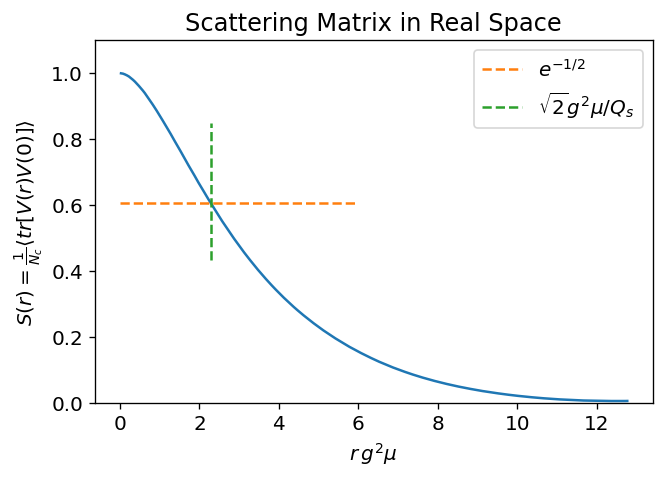

In [25]:
# The fundamental dipole S(r) in the coordinate space
plt.plot(r, S_b, '-')
plt.plot([0, 6], [np.exp(-0.5), np.exp(-0.5)], '--', label=r'$e^{-1/2}$')
plt.plot([muOverQs*np.sqrt(2), muOverQs*np.sqrt(2)], [np.exp(-0.5)/1.4, np.exp(-0.5)*1.4], '--', label=r'$\sqrt{2} g^2 \mu / Q_s$')

plt.ylim(0,1.1)
plt.legend()
plt.xlabel(r'$r \, g^2 \mu$')
plt.ylabel(r'$S(r) = \frac{1}{N_c} \langle tr [V(r) V(0)] \rangle $')
plt.title('Scattering Matrix in Real Space')
plt.show()

Now we'll do the same process of binning the scattering matrix in momentum space (though no interpolation here).

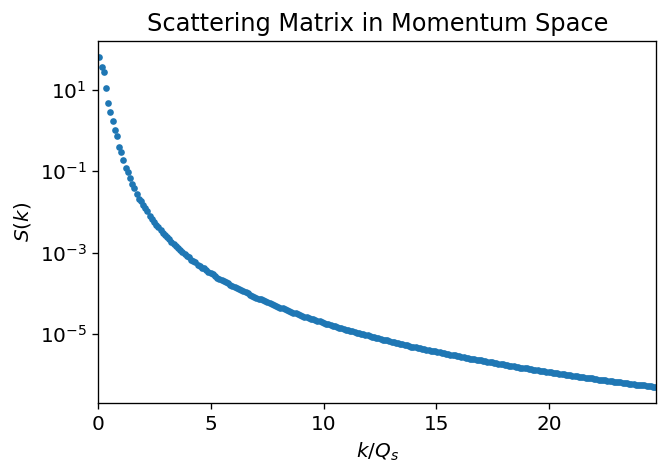

In [24]:
# Scattering matrix in momentum space 
S_fft_b = np.zeros(int(N/2), dtype='float')
n_fft_b = np.zeros(int(N/2), dtype='float')

deltak = 2.0/delta / (N/2) # maximum momentum = 2.0/delta; N/2 bins 

# Calculate the momentum at every point on the lattice
kComSqr = (2/delta * np.sin(np.pi*np.arange(N)/N))**2
kMag = np.sqrt(np.add.outer(kComSqr, kComSqr))

for i in range(int(N/2)):
    # Boolean expression finds the points that are between deltak*i and deltak*(i+1)
    n_fft_b[i] = len(S_fft[(kMag < deltak * (i+1)) & (kMag >= deltak * i)])
    S_fft_b[i] = np.sum(np.real(S_fft[(kMag < deltak * (i+1)) & (kMag >= deltak * i)])) / n_fft_b[i]


k = deltak*(np.arange(int(N/2))+0.5)
plt.plot(k/muOverQs, S_fft_b, '.')

plt.yscale('log')
plt.xlim(0, 2/delta/muOverQs)
#plt.ylim(1e-3,100)
plt.xlabel(r'$k/Q_s$')
plt.ylabel(r'$S(k)$');
plt.title('Scattering Matrix in Momentum Space')
plt.show()